Trying to reproduce results from [Chinchilla](https://arxiv.org/pdf/2203.15556.pdf):

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
gpt2 = dict(
    seq_len = 1024,
    vocab_size = 50257,
    d_model = 768,
    num_heads = 12,
    num_layers = 12,
)

## params

In [3]:
def params(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size=4):
    """ Given GPT config calculate total number of parameters""" 
    # token and position embeddings
    embeddings = d_model * vocab_size + d_model * seq_len
    # transformer blocks
    attention = 3*d_model**2 + 3*d_model # weights and biases
    attproj = d_model**2 + d_model
    ffw = d_model*(ffw_size*d_model) + ffw_size*d_model
    ffwproj = ffw_size*d_model*d_model + d_model
    layernorms = 2*2*d_model
    # dense
    ln_f = 2*d_model
    dense = d_model*vocab_size # note: no bias here
    # note: embeddings are not included in the param count!
    total_params = num_layers*(attention + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    return total_params

params(**gpt2)/1e6

123.653376

OpenAI reports gpt2 (small) as having 124M params, so this is a match. Also, loading the OpenAI weights into nanoGPT and then calling `model.parameters()` exactly matches the above number and verifies the implementation.

In [4]:
import json
chinchilla_models_txt = '[[44000000.0, 512, 2048, 64, 8, 8], [57000000.0, 576, 2304, 64, 9, 9], [74000000.0, 640, 2560, 64, 10, 10], [90000000.0, 640, 2560, 64, 10, 13], [106000000.0, 640, 2560, 64, 10, 16], [117000000.0, 768, 3072, 64, 12, 12], [140000000.0, 768, 3072, 64, 12, 15], [163000000.0, 768, 3072, 64, 12, 18], [175000000.0, 896, 3584, 64, 14, 14], [196000000.0, 896, 3584, 64, 14, 16], [217000000.0, 896, 3584, 64, 14, 18], [251000000.0, 1024, 4096, 64, 16, 16], [278000000.0, 1024, 4096, 64, 16, 18], [306000000.0, 1024, 4096, 64, 16, 20], [425000000.0, 1280, 5120, 128, 10, 18], [489000000.0, 1280, 5120, 128, 10, 21], [509000000.0, 1408, 5632, 128, 11, 18], [552000000.0, 1280, 5120, 128, 10, 24], [587000000.0, 1408, 5632, 128, 11, 21], [632000000.0, 1536, 6144, 128, 12, 19], [664000000.0, 1408, 5632, 128, 11, 24], [724000000.0, 1536, 6144, 128, 12, 22], [816000000.0, 1536, 6144, 128, 12, 25], [893000000.0, 1792, 7168, 128, 14, 20], [1018000000.0, 1792, 7168, 128, 14, 23], [1143000000.0, 1792, 7168, 128, 14, 26], [1266000000.0, 2048, 8192, 128, 16, 22], [1424000000.0, 2176, 8704, 128, 17, 22], [1429000000.0, 2048, 8192, 128, 16, 25], [1593000000.0, 2048, 8192, 128, 16, 28], [1609000000.0, 2176, 8704, 128, 17, 25], [1731000000.0, 2304, 9216, 128, 18, 24], [1794000000.0, 2176, 8704, 128, 17, 28], [2007000000.0, 2304, 9216, 128, 18, 28], [2283000000.0, 2304, 9216, 128, 18, 32], [2298000000.0, 2560, 10240, 128, 20, 26], [2639000000.0, 2560, 10240, 128, 20, 30], [2980000000.0, 2560, 10240, 128, 20, 34], [3530000000.0, 2688, 10752, 128, 22, 36], [3802000000.0, 2816, 11264, 128, 22, 36], [4084000000.0, 2944, 11776, 128, 22, 36], [4516000000.0, 3072, 12288, 128, 24, 36], [6796000000.0, 3584, 14336, 128, 28, 40], [9293000000.0, 4096, 16384, 128, 32, 42], [11452000000.0, 4352, 17408, 128, 32, 47], [12295000000.0, 4608, 18432, 128, 36, 44], [12569000000.0, 4608, 18432, 128, 32, 47], [13735000000.0, 4864, 19456, 128, 32, 47], [14940000000.0, 4992, 19968, 128, 32, 49], [16183000000.0, 5120, 20480, 128, 40, 47]]'
chilchilla_models = json.loads(chinchilla_models_txt) # all 50 models
chilchilla_models[0] # tuples of params, d_model, ffw_size, kv_size, n_heads, n_layers from Table A9

[44000000.0, 512, 2048, 64, 8, 8]

In [5]:
for m in chilchilla_models[:5]: # look at just first 5 models
    p, d, f, k, h, l = m
    nparams = params(seq_len = 1024, vocab_size = 32000, d_model = d, num_heads = h, num_layers = l)
    print(f"our estimated params: {nparams/1e6:.4f}M, chinchilla params: {p/1e6:.4f}M, d_model: {d}, n_heads: {h}, n_layers: {l}")

our estimated params: 41.6041M, chinchilla params: 44.0000M, d_model: 512, n_heads: 8, n_layers: 8
our estimated params: 54.3324M, chinchilla params: 57.0000M, d_model: 576, n_heads: 9, n_layers: 9
our estimated params: 69.7165M, chinchilla params: 74.0000M, d_model: 640, n_heads: 10, n_layers: 10
our estimated params: 84.4870M, chinchilla params: 90.0000M, d_model: 640, n_heads: 10, n_layers: 13
our estimated params: 99.2576M, chinchilla params: 106.0000M, d_model: 640, n_heads: 10, n_layers: 16


So we are not able to reproduce the parameter counts for the Chinchilla models. The claimed number of parameters is not the number of parameters we compute above. TODO: resolve... 

Now turning to FLOPs:

## flops

In [6]:
def flops(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size=4):
    """ 
    Given GPT config calculate total number of FLOPs, see Chinchilla 
    paper Appendix F as reference: https://arxiv.org/pdf/2203.15556.pdf
    """ 
    key_size = d_model // num_heads

    # embeddings
    embeddings = 2 * seq_len * vocab_size * d_model

    # attention
    # key, query, value projections
    attention = 2 * 3 * seq_len * d_model * (key_size * num_heads)
    # key @ query logits
    attlogits = 2 * seq_len * seq_len * (key_size * num_heads)
    # softmax
    attsoftmax = 3 * num_heads * seq_len * seq_len # 3* is for subtract (max), exp, divide (?)
    # softmax @ value reductions
    attvalue = 2 * seq_len * seq_len * (key_size * num_heads)
    # final linear
    attlinear = 2 * seq_len * (key_size * num_heads) * d_model
    att = attention + attlogits + attsoftmax + attvalue + attlinear
    # feed forward
    dense = 2 * seq_len * (d_model * ffw_size + d_model * ffw_size)

    # logits
    logits = 2 * seq_len * d_model * vocab_size

    forward_flops = embeddings + num_layers * (att + dense) + logits
    backward_flops = 2 * forward_flops # as in Kaplan et al. 2020
    total_flops = forward_flops + backward_flops

    return total_flops

flops(**gpt2)/1e9

766.006788096

In [7]:
# Now try reproduce Table A4 from Chinchilla paper Appendix, 
# comparing accurate flops above to approximate flops F = 6*N*D
# note Chinchilla mentions using vocab_size = 32K

args = dict(seq_len = 1024, vocab_size = 32000, d_model = 640, num_heads = 10, num_layers = 10) # chinchilla 73M

D = 1024 # dataset size (cancels anyway, for the purposes of the ratio calculation below)
N = params(**args)
F = flops(**args)

approx_flops = 6*D*N # approximate flops
chinch_flops = F * (float(D) / args['seq_len']) # exact flops according to Chinchilla paper calculations

print(f"params: {N/1e6:.2f}M")
print(f"approx flops: {approx_flops/1e9:.2f}B")
print(f"chinchilla flops: {chinch_flops/1e9:.2f}B")
print(f"ratio (chinchilla / approx): {chinch_flops / approx_flops:.2f}")

params: 69.72M
approx flops: 428.34B
chinchilla flops: 434.11B
ratio (chinchilla / approx): 1.01


Awkward because the ratio is supposed to be 1.03 but we get 1.01, e.g. for the 73M param model. So once again we don't reproduce the numbers. TODO resolve...

## scaling laws

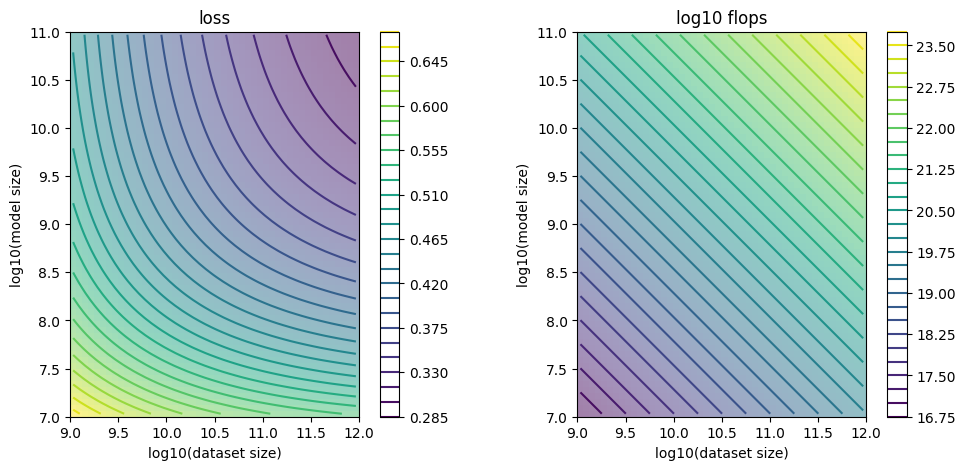

In [8]:
def L(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per Chinchilla paper.
    """
    E = 1.69 # entropy of natural language, limit of infinite model on infinite data
    A = 406.4
    B = 410.7
    alpha = 0.34
    beta = 0.28
    return A / (N ** alpha) + B / (D ** beta) + E

ns = 10 ** np.arange(7, 11, step=2**-4) # model sizes from 10M to 100B
ds = 10 ** np.arange(9, 12, step=2**-4) # dataset sizes from 1B to 1T
plt.figure(figsize=(12, 5))
plt.subplot(121)
# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds
loss2d = np.log10(np.array([[L(n, d) for d in ds] for n in ns]))
plt.imshow(loss2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(loss2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()
# plot the compute for each point, which is a deterministic function: flops = 6*N*D
plt.subplot(122)
compute2d = np.log10(np.array([[6*n*d for d in ds] for n in ns]))
plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

Ok so given any N,D we can estimate both: 1) the loss, and 2) the total flops. Now we want to solve the following problem: Given a specific budget of flops C, find: N_opt, D_opt = argmin_{FLOPs(N,D) = C} L(N, D). i.e. how big of a model should we train and for how many tokens?

best model size: 316.23M
best dataset size: 10.12B


Text(0, 0.5, 'loss')

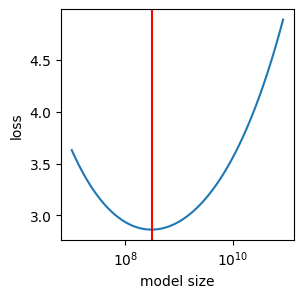

In [9]:
c = 1.92e19 # target compute budget (usually know this because we know how many GPU for how long go brrr)
# sweep model sizes from 10M to 100B
ns = 10 ** np.arange(7, 11, step=2**-4)
# using C = 6*N*D, solve for D that maintains the compute budget c
ds = c / (6 * ns)
# evaluate the loss in each case
losses = L(ns, ds)
# find the argmin
best = np.argmin(losses)
print(f"best model size: {ns[best]/1e6:.2f}M")
print(f"best dataset size: {ds[best]/1e9:.2f}B")
# plot the loss
plt.figure(figsize=(3,3))
plt.plot(ns, losses)
plt.xscale('log')
# plot a vertical bar at the best model size
plt.axvline(ns[best], color='red')
plt.xlabel('model size')
plt.ylabel('loss')

In the plot above, basically the models on the left of best are too small and trained for too long. The models on the right of best are way too large and trained for too little. The model at the red line is just right.

Now, the Chinchilla paper says that best model size is 400M params and 8B tokens, so this once again disagrees and there is some calculations problem. TODO figure out and fix...

In [10]:
# Calculate the Chinchilla optimal models for a range of compute budgets

# sweep over compute budgets from 1e17 to 1e26
cs = 10 ** np.arange(17, 26, step=2**-8)
models = []
for c in cs:
    # sweep over model sizes
    ns = 10 ** np.arange(7, 14, step=2**-8)
    # the dataset sizes that would maintain the given compute budget
    ds = c / (6 * ns)
    # losses at each point
    losses = L(ns, ds)
    # n,d for the best model
    best = np.argmin(losses)
    models.append((c, ns[best], ds[best])) # c, n, d tuple log

len(models)

2304

In [11]:
query_model_size = 1.3e9 # GPT-3 size
ns = np.array([n for c, n, d in models])
ds = np.array([d for c, n, d in models])
# find the index of the closest model size in ns
ix = np.argmin(np.abs(ns - query_model_size))
# retrieve the corresponding params, flops, and data size
print("closest model found:")
print(f"model size: {ns[ix]/1e6:.2f}M")
print(f"dataset size: {ds[ix]/1e9:.2f}B")
print(f"flops: {6*ns[ix]*ds[ix]:e}")
print(f"loss: {L(ns[ix], ds[ix]):.2f}")

closest model found:
model size: 1298.02M
dataset size: 60.32B
flops: 4.697589e+20
loss: 2.41


So we predict 60B tokens is compute optimal. But e.g. [MosaicML quotes 26B](https://t.co/HyEvCqP70C). So again wrong.

TLDR atm: nothing reproduces.